In [1]:
import numpy as np
import matplotlib.pyplot as plt

def render_pcl(df, indexing):
    _indexing = np.zeros(indexing.shape, dtype=np.int)
    index_mapping, index_ctr = {}, 0
    for vertex, index in enumerate(indexing):
        if index not in index_mapping:
            index_mapping[index] = index_ctr
            index_ctr += 1
        _indexing[vertex] = index_mapping[index]
    df["partition"] = _indexing
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    for part_idx in range(max(df["partition"])+1):
        samples = df[df["partition"] == part_idx]
        samples = samples[["x","y","z"]].to_numpy()
        ax.scatter(samples[:,0], samples[:,1], samples[:,2], marker=".")
    plt.show()

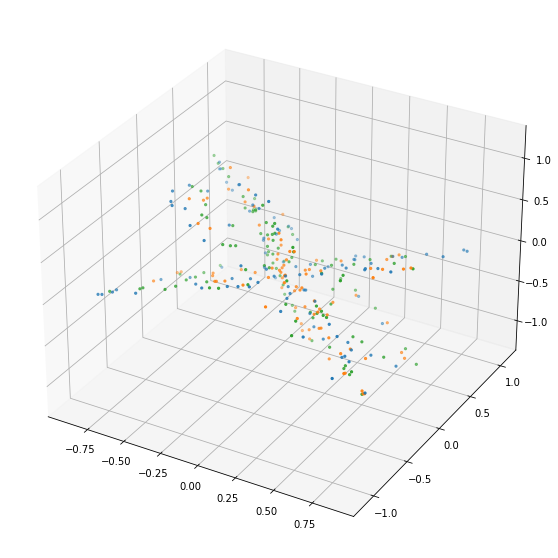

In [3]:
from mlcv import initialize_indexing, neighbours, generate_points
from mlcv import sample_move_diff_cost, cf, cf_prime

df = generate_points([0.001,0.001,0.001],[100,100,100])
indexing = np.random.choice(3,df.shape[0])
df["assigned_partition"] = indexing

render_pcl(df, indexing)

# for v,k in neighbours(indexing, randomize=True):
#     cost = sample_move_diff_cost(df, "assigned_partition", cf, cf_prime, v, k, 30 )
#     print(cost)
